# Data exploration in SAR Images - Using Numpy arrays

make a distribution analysis by array, combine them all together, and make a distribution with all of them and see what I get

In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../..'))

from offshore_wind_nj.data_loader import data_files, load_data, all_arrays
from offshore_wind_nj.sar_wind_plot import plot_wind_field
load_data(data_files) # Load the files in the module 'data_loader'

2024-10-26 14:17:30.955 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore Wind Research


There are 5773 files


# Load all the arrays
Data is read, and append in the list 'all_arrays'

In [2]:
all_arrays[0][0].shape#[...,254].shape

(167, 255)

In [3]:
from scipy.ndimage import zoom
zoom(all_arrays[0][0],0.5).shape

(84, 128)

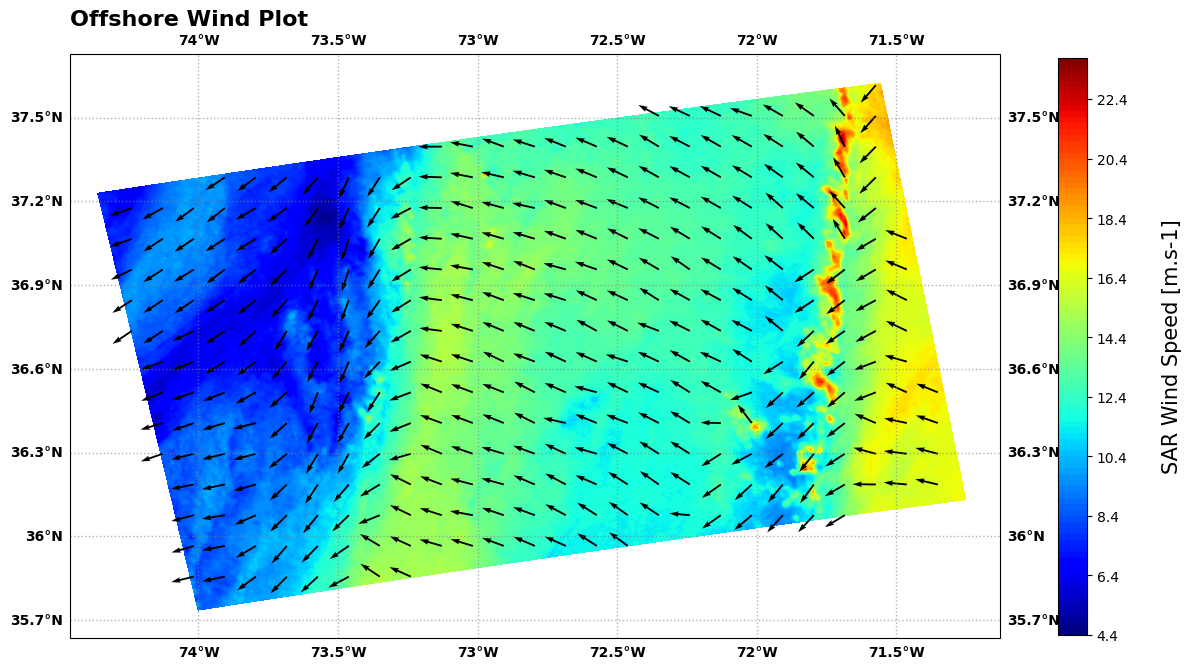

In [4]:
owiSpeed = all_arrays[0][0]
owiDir = all_arrays[0][1]
lat = all_arrays[0][2]
lon = all_arrays[0][3]

plot_wind_field(owiSpeed, owiDir, lat, lon)

In [5]:
from datetime import datetime
file_path = data_files[0]
timestamp_str = file_path.stem.split('_')[6]  # Extract the timestamp section
timestamp_str
timestamp = datetime.strptime(timestamp_str, '%Y%m%dT%H%M%S').strftime('%Y-%m-%d %H:%M:%S')
timestamp

'2019-04-20 22:50:14'

# Determine maximum lengths and columns for each array

In [6]:
max_length = max(arr[0].shape[0] for arr in all_arrays)

max_columns_wind_speed = max(arr[0].shape[1] for arr in all_arrays)
max_columns_wind_direction = max(arr[1].shape[1] for arr in all_arrays)
max_columns_latitude = max(arr[2].shape[1] for arr in all_arrays)
max_columns_longitude = max(arr[3].shape[1] for arr in all_arrays)

# Note that the rows & columns are consistent in each image. In other words, wind, direction, lat & lon have the same shape per image

## Pad each array and stack along a new third axis (depth-wise)

In [7]:
padded_data = []

for wind_speed, wind_direction, latitude, longitude in all_arrays:
    padded_wind_speed = np.pad(wind_speed, 
                               ((0, max_length - wind_speed.shape[0]), 
                                (0, max_columns_wind_speed - wind_speed.shape[1])), 
                               mode='constant', constant_values=np.nan)
    
    padded_wind_direction = np.pad(wind_direction, 
                                   ((0, max_length - wind_direction.shape[0]), 
                                    (0, max_columns_wind_direction - wind_direction.shape[1])), 
                                   mode='constant', constant_values=np.nan)
    
    padded_latitude = np.pad(latitude, 
                             ((0, max_length - latitude.shape[0]), 
                              (0, max_columns_latitude - latitude.shape[1])), 
                             mode='constant', constant_values=np.nan)
    
    padded_longitude = np.pad(longitude, 
                              ((0, max_length - longitude.shape[0]), 
                               (0, max_columns_longitude - longitude.shape[1])), 
                              mode='constant', constant_values=np.nan)
    
    # Stack padded arrays along a new third axis
    combined = np.dstack((padded_wind_speed, 
                          padded_wind_direction, 
                          padded_latitude, 
                          padded_longitude))
    
    padded_data.append(combined)

# Example: Access the combined array for the first SAR image
print(padded_data[0].shape)

(241, 286, 4)


- The array 'padded_data' contains the 5774 images. Each image has a shape of (241, 286, 4); there are 241 arrays and each of them has a shape of (286, 4). 

In [8]:
padded_data[0][...,3]

array([[-74.00143 , -73.99057 , -73.97971 , ...,        nan,        nan,
               nan],
       [-74.00357 , -73.99271 , -73.98185 , ...,        nan,        nan,
               nan],
       [-74.00571 , -73.99485 , -73.983986, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

* [..., 0] and [:, :, 0] are similar in that they both select the first element along the last dimension of an array, but they differ in how they specify the preceding dimensions.

In [9]:

valid_data_masks = []  # Will hold valid (non-nan) masks for each image

for wind_speed, wind_direction, latitude, longitude in all_arrays:
    # Create a mask for valid (non-NaN) points
    valid_mask = ~np.isnan(wind_speed) & ~np.isnan(wind_direction)
    
    # Store the valid mask for later
    valid_data_masks.append(valid_mask)

# Let's print the shape of one of the valid masks to confirm it matches the original array
print(valid_data_masks[0].shape)  # Should match original wind_speed shape


(167, 255)


### Finding files acording to speed values
- file S1A_IW_OCN__2SDV_20170403T222528_20170403T222553_015986_01A5DF_AE79 came with a very high wind speed, need to check why - It seems this file was damaged

In [33]:
def check_speed(arr):
    return np.any(arr[..., 0] == 0)
speed_indices = [i for i, arr in enumerate(padded_data) if check_speed(arr)]
# l = []
# for i in range(len(all_arrays)):
#     l.append(i)
#     # if kde=True, color='blue'(all_arrays[i][0]):#.shape
#         # print (i)
len(speed_indices)

1346

In [36]:
speed_indices[0]

10

In [39]:
data_files[10]

PosixPath('/nfs/storage1/home/noriegac/Documents/Offshore Wind Research/data/processed/S1A_IW_OCN__2SDV_20150731T222600_20150731T222628_007061_0099AE_05B7.npz')

In [41]:
from pathlib import PosixPath

def extract_filename_without_extension(file_path):
    # Ensure the input is a PosixPath object
    if isinstance(file_path, PosixPath):
        return file_path.stem  # Get the filename without the extension
    else:
        raise ValueError("Input must be a PosixPath object.")

# Example usage
# file_path = PosixPath('/nfs/storage1/home/noriegac/Documents/Offshore Wind Research/data/processed/S1A_IW_OCN__2SDV_20150731T222600_20150731T222628_007061_0099AE_05B7.npz')
filename_without_extension = extract_filename_without_extension(data_files[10])
print(filename_without_extension)  # Output: S1A_IW_OCN__2SDV_20150731T222600_20150731T222628_007061_0099AE_05B7


S1A_IW_OCN__2SDV_20150731T222600_20150731T222628_007061_0099AE_05B7


In [38]:
all_arrays[10][0]

array([[4.5013256, 6.1788177, 6.248541 , ..., 5.38965  , 5.387346 ,
        5.3801827],
       [4.482617 , 5.8353024, 5.8810997, ..., 5.46123  , 5.449244 ,
        5.516598 ],
       [4.6505117, 5.715635 , 5.536841 , ..., 5.5885844, 5.7025547,
        5.650661 ],
       ...,
       [3.3900952, 3.3475828, 3.3238745, ..., 0.       , 0.       ,
        0.       ],
       [3.5517235, 3.5767636, 3.2967858, ..., 0.       , 0.       ,
        0.       ],
       [1.3825192, 1.2764745, 1.4671897, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

# Analysis Wind Speed

In [11]:
all_wind_speeds = np.concatenate([arr[..., 0].flatten() for arr in padded_data])
filtered_wnd_speed = all_wind_speeds[~np.isnan(all_wind_speeds)]
len(all_wind_speeds)


397909798

## Visualizing the distribuition of the speeds

Mean Wind Speed: 7.23
Median Wind Speed: 6.72
Skewness of Wind Speed Distribution: 0.45
Identified Outliers: [21.04554  19.859734 20.515032 ... 19.7      20.       19.8     ]


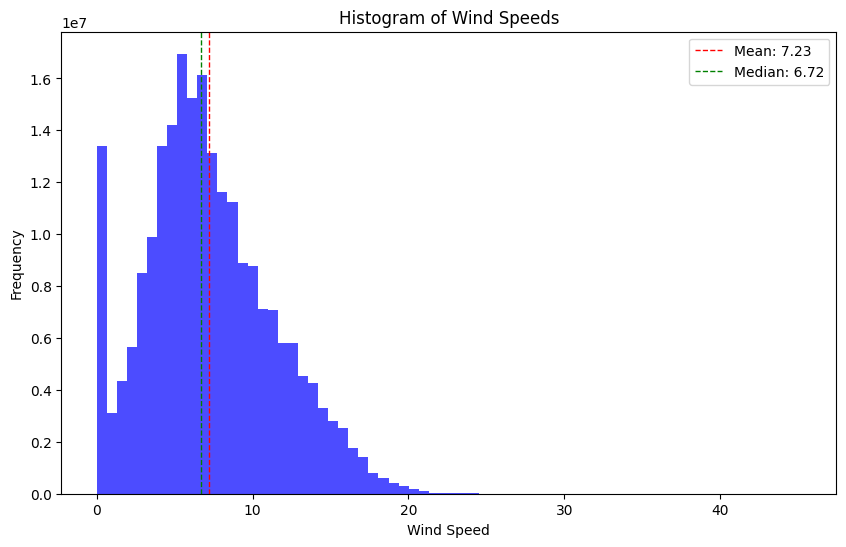

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, zscore

# Assuming all_wind_speeds is your NumPy array with potential np.nan values
mean_speed = np.nanmean(all_wind_speeds)
median_speed = np.nanmedian(all_wind_speeds)
skewness = skew(all_wind_speeds, nan_policy='omit')  # Skew ignores NaNs

# Z-score for identifying outliers, ignoring NaNs
z_scores = zscore(all_wind_speeds, nan_policy='omit')
outliers = all_wind_speeds[np.abs(z_scores) > 3]  # Common threshold for outliers

# Display statistics
print(f"Mean Wind Speed: {mean_speed:.2f}")
print(f"Median Wind Speed: {median_speed:.2f}")
print(f"Skewness of Wind Speed Distribution: {skewness:.2f}")
print(f"Identified Outliers: {outliers}")

plt.figure(figsize=(10, 6))
plt.hist(all_wind_speeds[~np.isnan(all_wind_speeds)], bins=70, color='blue', alpha=0.7)

# Plotting mean and median
plt.axvline(mean_speed, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_speed:.2f}')
plt.axvline(median_speed, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_speed:.2f}')

plt.title('Histogram of Wind Speeds')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Normalizing Speed data
### z-scores

In [16]:
# Calculate mean and std ignoring NaNs
mean_speed = np.nanmean(all_wind_speeds)
std_speed = np.nanstd(all_wind_speeds)

# Z-score normalization
normalized_speeds = (all_wind_speeds - mean_speed) / std_speed


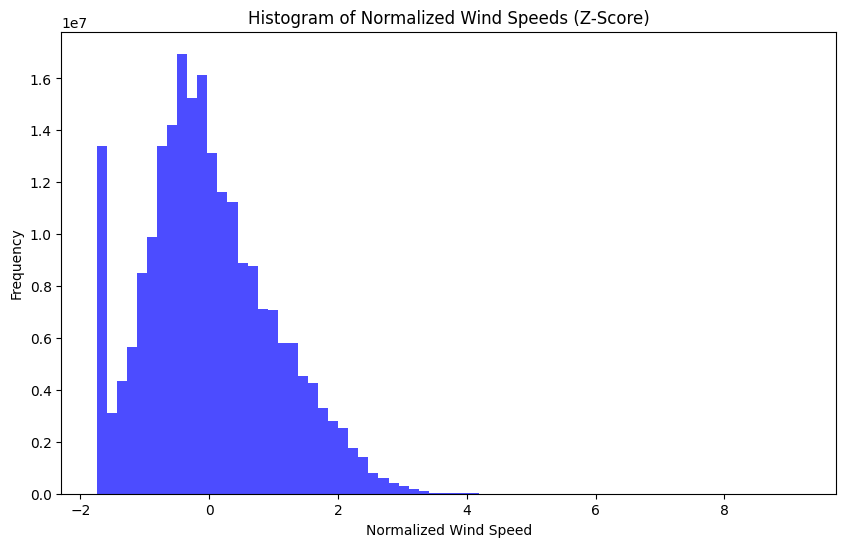

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(normalized_speeds[~np.isnan(normalized_speeds)], bins=70, color='blue', alpha=0.7)
plt.title('Histogram of Normalized Wind Speeds (Z-Score)')
plt.xlabel('Normalized Wind Speed')
plt.ylabel('Frequency')
plt.show()

## Creating the mask to remove values where the speed is 0 and greater than 40

In [80]:
valid_mask = (all_wind_speeds>0) & (all_wind_speeds<40)
valid_mask_with_zeros = all_wind_speeds<500

len(all_wind_speeds[valid_mask])

214638526

In [81]:
filtered_wnd_speed = all_wind_speeds[valid_mask]
mean_wind_speed = np.mean(filtered_wnd_speed)
std_wind_speed = np.std(filtered_wnd_speed)

normalized_wind_speed = (filtered_wnd_speed - mean_wind_speed) / std_wind_speed

In [89]:
mean_wind_speed = np.mean(filtered_wnd_speed)
median_wind_speed = np.median(filtered_wnd_speed)
std_wind_speed = np.std(filtered_wnd_speed)
min_wind_speed = np.min(filtered_wnd_speed)
max_wind_speed = np.max(filtered_wnd_speed)

print(f"Mean = {mean_wind_speed}")
print(f"Median = {median_wind_speed}")
print(f"Std = {std_wind_speed}")
print(f"Min = {min_wind_speed}")
print(f"Max = {max_wind_speed}")
      
      


Mean = 7.521703720092773
Median = 6.900000095367432
Std = 3.941035747528076
Min = 2.802709673233039e-07
Max = 39.971290588378906


In [22]:
plt.figure(figsize=(10,6))
plt.hist(normalized_wind_speed, bins=70, color='blue', alpha=0.7, kde=True)

plt.title('Histogram of Normalized Wind Speeds - After removing values with 0 speed')
plt.xlabel('Normalized Wind Speed (z-score)')
plt.ylabel('Frequency')
plt.show()

NameError: name 'normalized_wind_speed' is not defined

<Figure size 1000x600 with 0 Axes>

In [92]:
from scipy.stats import skew, kurtosis

skewness = skew(normalized_wind_speed)
kurt = kurtosis(normalized_wind_speed)
# plt.boxplot(normalized_wind_speed, vert=False)
# plt.show()

In [95]:
skewness

0.5687954539981539

# Direction

In [110]:
all_wind_directions = np.concatenate([arr[:, :, 1].flatten() for arr in padded_data])


In [111]:
np.min(all_wind_directions[~np.isnan(all_wind_directions)])

0.0

In [113]:
len(all_wind_directions)

397978724

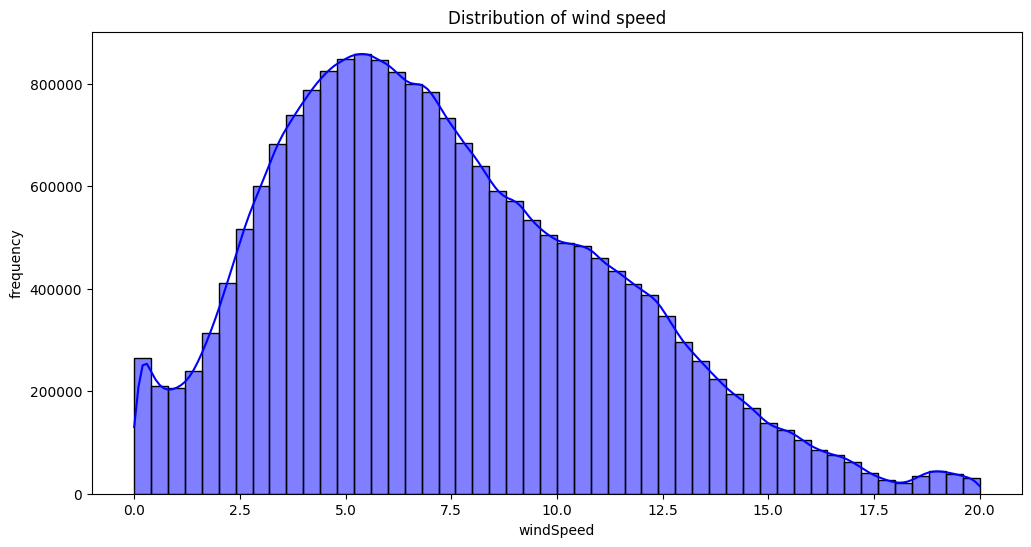

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.histplot(all_wind_speeds[valid_mask][:20000000], bins=50, kde=True, color='blue')
plt.title('Distribution of wind speed')
plt.xlabel('windSpeed')
plt.ylabel('frequency')
plt.show()

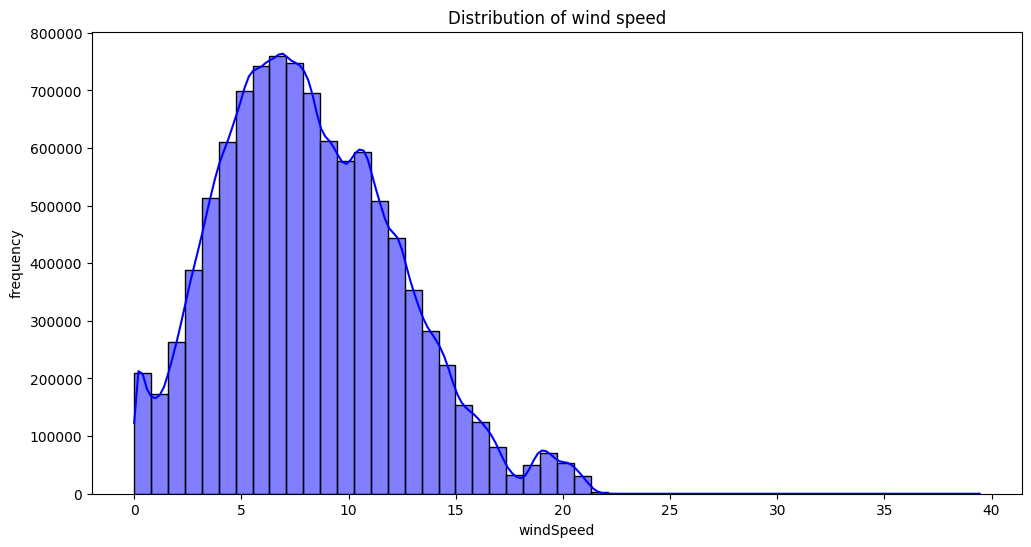

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.histplot(all_wind_speeds[valid_mask][10000000:20000000], bins=50, kde=True, color='blue')
plt.title('Distribution of wind speed')
plt.xlabel('windSpeed')
plt.ylabel('frequency')
plt.show()

# Apply the clustering... (still in review)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Extract valid data points based on the valid mask
valid_data_points = []

for idx, (wind_speed, wind_direction, latitude, longitude) in enumerate(all_arrays):
    # Get the valid mask for this image
    valid_mask = valid_data_masks[idx]
    
    # Extract only valid (non-nan) data points for each feature
    valid_wind_speed = wind_speed[valid_mask]
    valid_wind_direction = wind_direction[valid_mask]
    valid_latitude = latitude[valid_mask]
    valid_longitude = longitude[valid_mask]
    
    # Combine the valid data points into a single array (rows: valid pixels, columns: features)
    valid_combined = np.column_stack((valid_wind_speed, valid_wind_direction, valid_latitude, valid_longitude))
    
    valid_data_points.append(valid_combined)

# Step 2: Stack all valid data points across images into one large dataset
all_valid_data = np.vstack(valid_data_points)

# Step 3: Normalize the data
scaler = StandardScaler()
all_valid_data_scaled = scaler.fit_transform(all_valid_data)

# Step 4: Apply K-Means Clustering
n_clusters = 2  # Adjust based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_valid_data_scaled)

# Step 5: Get cluster labels
cluster_labels = kmeans.labels_

# Step 6: Now, we need to assign the cluster labels back to the valid points in the original images
reshaped_labels = []
start_idx = 0

for idx, valid_mask in enumerate(valid_data_masks):
    num_valid_points = np.sum(valid_mask)  # Number of valid data points in this image
    
    # Extract the cluster labels corresponding to the valid points for this image
    labels = cluster_labels[start_idx:start_idx + num_valid_points]
    
    # Create an empty array to store the labels, with the same shape as the padded arrays
    label_array = np.full(valid_mask.shape, np.nan)  # Fill with np.nan for invalid points
    
    # Fill valid points with cluster labels
    label_array[valid_mask] = labels
    
    reshaped_labels.append(label_array)  # Add to the list of reshaped labels
    
    # Move to the next set of labels in the cluster_labels array
    start_idx += num_valid_points

# The reshaped_labels list now contains the cluster labels for each image, with np.nan in padded areas


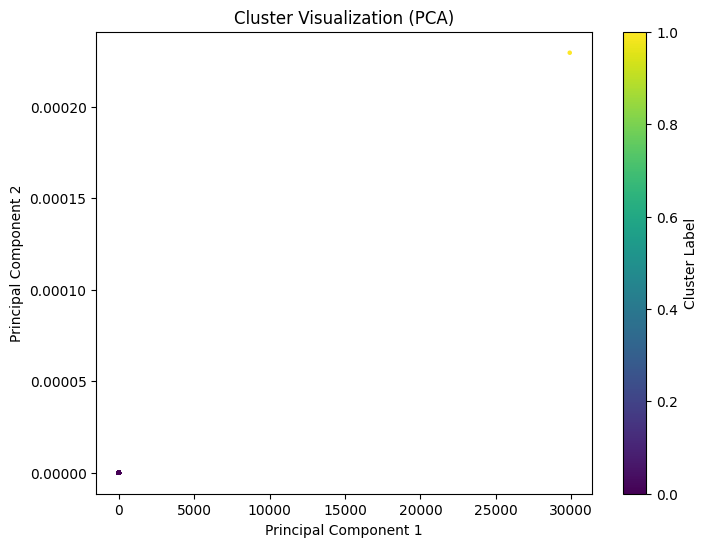

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(all_valid_data_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='viridis', s=5)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Flatten each combined 3D array into a 2D array
# Shape before flattening: (max_length, max_columns, 4)
# Shape after flattening: (max_length * max_columns, 4)

flattened_data = []
for combined_array in padded_data:
    # Flatten to shape (max_length * max_columns, 4)
    flattened_array = combined_array.reshape(-1, 4)  # Flatten spatial dimensions, keep feature layers
    flattened_data.append(flattened_array)

# Step 2: Stack all flattened arrays into one dataset
# Concatenate to shape (n_samples, 4), where n_samples = sum of all image sizes
all_data = np.vstack(flattened_data)

# Step 3: Remove rows with np.nan (in case some areas were padded)
all_data_clean = all_data[~np.isnan(all_data).any(axis=1)]

# Step 4: Normalize the data to ensure each feature is on the same scale
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data_clean)

# Step 5: Apply K-Means Clustering (you can try other algorithms too)
n_clusters = 5  # Set number of clusters (can be adjusted)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_data_scaled)

# Step 6: Get the cluster labels
cluster_labels = kmeans.labels_

# Step 7: Reshape the cluster labels back into the original spatial structure (for visualization)
reshaped_labels = []
start_idx = 0

for combined_array in padded_data:
    original_shape = combined_array.shape[:2]  # (max_length, max_columns)
    num_pixels = original_shape[0] * original_shape[1]
    
    # Extract the corresponding labels for this image and reshape
    labels = cluster_labels[start_idx:start_idx + num_pixels]
    reshaped_labels.append(labels.reshape(original_shape))
    
    start_idx += num_pixels

# Now, reshaped_labels contains the clustering result for each SAR image
print(reshaped_labels[0].shape)  # Shape of the clustering result for the first image


/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


ValueError: cannot reshape array of size 52461 into shape (241,286)

In [145]:
padded_longitude.shape#[:241,:]

(241, 286)

In [98]:
max_columns_longitude

286

In [99]:
max_columns_wind_direction

286

In [100]:
max_columns_wind_speed

286